# 10 x 10 Ising Model Phase Classification using Feedforward Neural Network

### By Ben Wong

<h4>1: Data Processing.</h4>

In [90]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

!git clone https://github.com/DavidGoing/PHYS3151-Machine-Learning-in-Physics-2024

fatal: destination path 'PHYS3151-Machine-Learning-in-Physics-2024' already exists and is not an empty directory.


In [91]:
# import configurations
X = pd.read_csv("PHYS3151-Machine-Learning-in-Physics-2024/feedforward-neural-network/Ising/Ising_conf.csv", header=None) 
X = np.array(X)

# obtain mean and sd over each columns
X_mean = np.mean(X, axis=0)
X_sd = np.std(X, axis=0)
X_standardized = np.zeros(X.shape)

# standardized configurations 
for i in range(X.shape[1]):
    X_standardized[:,i] = (X[:,i] - X_mean[i]) / X_sd[i]

In [92]:
# import temperature
Y_temp = pd.read_csv("PHYS3151-Machine-Learning-in-Physics-2024/feedforward-neural-network/Ising/Ising_temp.csv", header=None) 
Y_temp = np.array(Y_temp)
Y = np.empty_like(Y_temp)

# modifying labels => ordered vs disordered
for i in range(Y_temp.shape[0]):
    if Y_temp[i,0] < 2.269:
        Y[i,0] = 1
    else:
        Y[i,0] = 0

<h4>2: Model Construction.</h4>

In [93]:
# diff = True => return derivative of sigmoid
def sigmoid(z, diff = False):
    if diff == False:
        return 1.0/(1.0+np.exp(-z))
    else: 
        return sigmoid(z)*(1-sigmoid(z))

In [94]:
class Network:
    
    # sizes = [2,2,1] => 2 input neurons + 2 hidden neurons + 1 output neuron
    def __init__(self, sizes): 
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    
    # forward propagation # x is input
    # activations_zs = True => return the lists of activations and zs in that forward propagation
    def forward_propagation(self, x, activations_zs = False):
        x = x.reshape((self.sizes[0],1))
        zs = []
        activations = [x]
        a = x
        
        for w, b in zip(self.weights, self.biases):
            z = (w @ a) + b
            zs.append(z)
            a = sigmoid(z)
            activations.append(a)
            
        if activations_zs == True:
            return a, activations, zs
        else:
            return a
    
    # return dJ/dtheta for every weights and biases through one back propagration
    # activations and zs from forward propagation are required
    def back_propagration(self, y, activations, zs):
        dJdthe_b = [np.zeros(b.shape) for b in self.biases]
        dJdthe_w = [np.zeros(w.shape) for w in self.weights]
                        
        # back propagration => obtain dJdthe_w and dJdthe_b
        # last layer
        delta = ( activations[-1] - y ) * sigmoid(zs[-1], diff = True)
        dJdthe_b[-1] = delta 
        dJdthe_w[-1] = delta @ activations[-2].T
        
        # from second last layer to the front
        for layer in range(2, self.num_layers):
            delta = ( self.weights[-layer + 1].T @ delta ) * sigmoid(zs[-layer], diff = True)
            dJdthe_b[-layer] = delta 
            dJdthe_w[-layer] = delta @ activations[-layer - 1].T  
            
        return (dJdthe_w, dJdthe_b)
    
    # gradient descent 
    def optimization(self, X_train, Y_train, eta, epochs, calculate_cost = False, X_test = None, Y_test = None):
        
        start_time = time.time()
        
        train_costs = [] # train_costs calculated from training set 
        val_costs = [] # val__costs calculated from test set 
        
        for i in range(epochs):
            # loop over each examples in training set
            for x, y in zip(X_train, Y_train):

                # use forward_propagation and back_propagration to obtain the gradient of cost function
                a, activations, zs = self.forward_propagation(x, activations_zs =True)
                dJdthe_w, dJdthe_b = self.back_propagration(y, activations, zs)

                # update the weights and biases
                self.weights = [w - eta * dJ for w, dJ in zip(self.weights, dJdthe_w)]
                self.biases = [b - eta * dJ for b, dJ in zip(self.biases, dJdthe_b)]
            
            # store the cost for each iteration calculated from training set
            train_costs.append(self.mean_squared_error(X_train, Y_train))
            val_costs.append(self.mean_squared_error(X_test, Y_test))
            
            completion_per = (i + 1) / epochs * 100
            # check if the completion percentage is a multiple of 10
            if completion_per % 10 == 0:
                print("Epoch: {}/{} - {}% complete".format(i + 1, epochs, completion_per))
        
        end_time = time.time()
        elapsed_time = (end_time - start_time) / 60
        print('')
        print(f'Elapsed time: {elapsed_time:.2f}  minutes')

        if calculate_cost:
            return train_costs, val_costs
        
    #predict the output     
    def predict(self, X_test):
        results = []
        for x in X_test:
            a = self.forward_propagation(x)
            if a[0,0] >= 0.5:
                results.append(1)
            else:
                results.append(0)
        return np.array(results)
    
    # cost function is defined as mean squared error
    def mean_squared_error(self, X, Y):
        m = X.shape[0]
        outputs = []
        for x in X:
            output = self.forward_propagation(x)
            outputs.append(output[0,0])
        outputs = np.array(outputs)
        mse = sum((output - y) ** 2 for output, y in zip(outputs, Y)) / m
        return mse

In [95]:
network = Network([100,3,1])

<h4>3: Model Training.</h4>


In [96]:
def train_test_split(X, Y, num_train):
    # concatenate X and Y as one 2d array
    data = np.concatenate((X,Y), axis=1)
    np.random.shuffle(data)
    train_data = data[:num_train]
    test_data = data[num_train:]
    
    # return X_train, Y_train, X_test, Y_test
    return train_data[:, :-1], train_data[:, -1] , test_data[:, :-1], test_data[:, -1] 

In [97]:
# 1000 training data and 5000 testing data
X_train, Y_train, X_test, Y_test = train_test_split(X_standardized, Y, num_train = 1000)

In [98]:
# cost_1 => list of costs of network_1 calculated from training set 
# accuracys_1_train => list of Aaccuracy of network_1 calculated from training set
# accuracys_1_test => list of Aaccuracy of network_1 calculated from test set
train_costs, val_costs  = network.optimization(X_train, Y_train, eta = 0.1, epochs = 1000, calculate_cost = True,  
                     X_test = X_test, Y_test = Y_test)

Epoch: 100/1000 - 10.0% complete
Epoch: 200/1000 - 20.0% complete
Epoch: 300/1000 - 30.0% complete
Epoch: 400/1000 - 40.0% complete
Epoch: 500/1000 - 50.0% complete
Epoch: 600/1000 - 60.0% complete
Epoch: 700/1000 - 70.0% complete
Epoch: 800/1000 - 80.0% complete
Epoch: 900/1000 - 90.0% complete
Epoch: 1000/1000 - 100.0% complete

Elapsed time: 9.09  minutes


<h4>4: Model Evaluation.</h4>


In [99]:
# lists of output neurons for two networks
out_neus = []

# forward_propagation
for x in X_standardized:
    y_pred = network.forward_propagation(x)
    out_neus.append(y_pred[0,0])


out_neus = np.array(out_neus)

# mean value of all outputs of network 1 with the same temperature
df = pd.DataFrame({'output': out_neus, 'temp': Y_temp.reshape(6000,)})
mn_output = df.groupby('temp').mean()

Text(0.5, 1.0, 'Training and Validation Losses')

<Figure size 400x400 with 0 Axes>

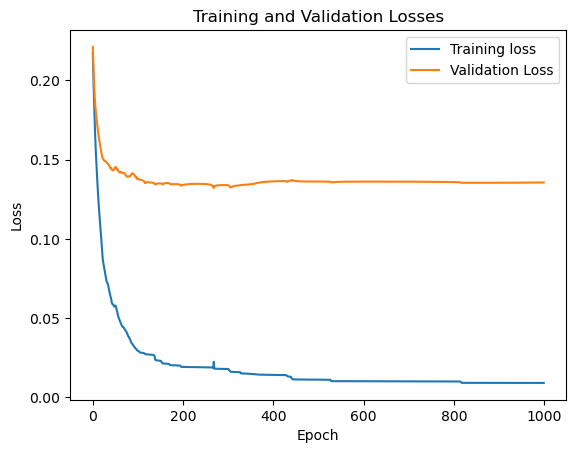

In [101]:
plt.figure(figsize=(4, 4))
losses = pd.DataFrame(data = {'Training loss': train_costs, 'Validation Loss': val_costs})
losses.plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

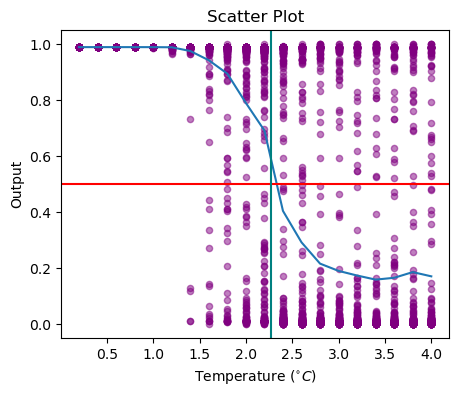

In [102]:
plt.figure(figsize=(5, 4))
plt.scatter(Y_temp, out_neus, color='purple', alpha=0.5, s=20)
plt.plot(mn_output.index, mn_output.values)
plt.title('Scatter Plot')
plt.xlabel(r'Temperature ($^{\circ}C$)')
plt.ylabel('Output')
plt.axhline(y=0.5, color='red')
plt.axvline(x=2.269, color='teal')